In [1]:
from functools import reduce
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [2]:
df = spark.read.csv('./dataset/Fraud.csv', header=True, inferSchema=True)
df.createOrReplaceTempView('fraud')

- step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
- type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
- amount - amount of the transaction in local currency.
- nameOrig - customer who started the transaction
- oldbalanceOrg - initial balance before the transaction
- newbalanceOrig - new balance after the transaction
- nameDest - customer who is the recipient of the transaction
- oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
- newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).
- isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
- isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [3]:
sql_script = \
"""
SELECT *
FROM fraud
WHERE isFraud = 1
LIMIT 20
"""
spark.sql(sql_script).toPandas()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
1,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0
2,1,TRANSFER,2806.00,C1420196421,2806.00,0.0,C972765878,0.00,0.00,1,0
3,1,CASH_OUT,2806.00,C2101527076,2806.00,0.0,C1007251739,26202.00,0.00,1,0
4,1,TRANSFER,20128.00,C137533655,20128.00,0.0,C1848415041,0.00,0.00,1,0
5,1,CASH_OUT,20128.00,C1118430673,20128.00,0.0,C339924917,6268.00,12145.85,1,0
6,1,CASH_OUT,416001.33,C749981943,0.00,0.0,C667346055,102.00,9291619.62,1,0
7,1,TRANSFER,1277212.77,C1334405552,1277212.77,0.0,C431687661,0.00,0.00,1,0
8,1,CASH_OUT,1277212.77,C467632528,1277212.77,0.0,C716083600,0.00,2444985.19,1,0
9,1,TRANSFER,35063.63,C1364127192,35063.63,0.0,C1136419747,0.00,0.00,1,0


In [4]:
dfs = []
for col in df.columns:
    sql_script = \
    f"""
        SELECT 
            COUNT(DISTINCT {col}) AS {col}
        FROM fraud
        ;
    """
    temp_df = spark.sql(sql_script).toPandas()
    dfs.append(temp_df)

count_unique_category = reduce(lambda left,right: pd.merge(left,right, left_index=True, right_index=True),dfs)
display(count_unique_category.T)

,0
step,743
type,5
amount,5316900
nameOrig,6353307
oldbalanceOrg,1845844
newbalanceOrig,2682586
nameDest,2722362
oldbalanceDest,3614697
newbalanceDest,3555499
isFraud,2


In [5]:
dfs = []
for col in df.columns:
    sql_script = \
    f"""
        SELECT
            SUM(
                CASE
                    WHEN {col} IS NULL THEN 1
                    ELSE 0
                END
            ) as {col}
        FROM fraud
    """
    temp_df = spark.sql(sql_script).toPandas()
    dfs.append(temp_df)
count_null_category = reduce(lambda left,right: pd.merge(left,right, left_index=True, right_index=True),dfs)

dfs = []
for col in df.columns:
    sql_script = \
    f"""
        SELECT
            SUM(
                CASE
                    WHEN {col} IS NULL THEN 0
                    ELSE 1
                END
            ) as {col}
        FROM fraud
    """
    temp_df = spark.sql(sql_script).toPandas()
    dfs.append(temp_df)
count_non_null_category = reduce(lambda left,right: pd.merge(left,right, left_index=True, right_index=True),dfs)


count_null_category = count_null_category.T
count_null_category.columns = ['null_count']
count_non_null_category = count_non_null_category.T
count_non_null_category.columns = ['non_null']

temp = pd.merge(count_non_null_category,count_null_category,left_index=True, right_index=True)
display(temp)


,non_null,null_count
step,6362620,0
type,6362620,0
amount,6362620,0
nameOrig,6362620,0
oldbalanceOrg,6362620,0
newbalanceOrig,6362620,0
nameDest,6362620,0
oldbalanceDest,6362620,0
newbalanceDest,6362620,0
isFraud,6362620,0


In [6]:
sql_script = \
"""
SELECT 
    type_of_sender,
    type_of_receiver,
    SUM(isFraud) AS total_fraud
FROM (    
    SELECT 
        (CASE
            WHEN nameOrig LIKE "M%" THEN 'Merchants'
            ELSE 'Customers'
        END) AS type_of_sender,
        (CASE
            WHEN nameDest LIKE "M%" THEN 'Merchants'
            ELSE 'Customers'
        END) AS type_of_receiver,
        isFraud
    FROM fraud
    ) a
GROUP BY type_of_sender, type_of_receiver
"""
spark.sql(sql_script).toPandas()

,type_of_sender,type_of_receiver,total_fraud
0,Customers,Customers,8213
1,Customers,Merchants,0


In [3]:
sql_script = \
"""
SELECT 
    type,
    COUNT(type) AS num,
    SUM(isFraud) AS isFraud,
    ROUND(100*SUM(isFraud)/COUNT(type) ,2) AS fraud_percent,
    SUM(isFlaggedFraud) AS flag,
    ROUND(100*SUM(isFlaggedFraud)/COUNT(type) ,2) AS flag_percent
FROM fraud
GROUP BY type
"""

spark.sql(sql_script).show()

+--------+-------+-------+-------------+----+------------+
|    type|    num|isFraud|fraud_percent|flag|flag_percent|
+--------+-------+-------+-------------+----+------------+
|TRANSFER| 532909|   4097|         0.77|  16|         0.0|
| CASH_IN|1399284|      0|          0.0|   0|         0.0|
|CASH_OUT|2237500|   4116|         0.18|   0|         0.0|
| PAYMENT|2151495|      0|          0.0|   0|         0.0|
|   DEBIT|  41432|      0|          0.0|   0|         0.0|
+--------+-------+-------+-------------+----+------------+



In [5]:
sql_script = \
"""
SELECT * 
FROM fraud
WHERE type IN ('TRANSFER','CASH_OUT')
"""
filtered_df = spark.sql(sql_script)
filtered_df.createOrReplaceTempView('filtered_fraud')
filtered_df.count()

2770409

<BarContainer object of 743 artists>

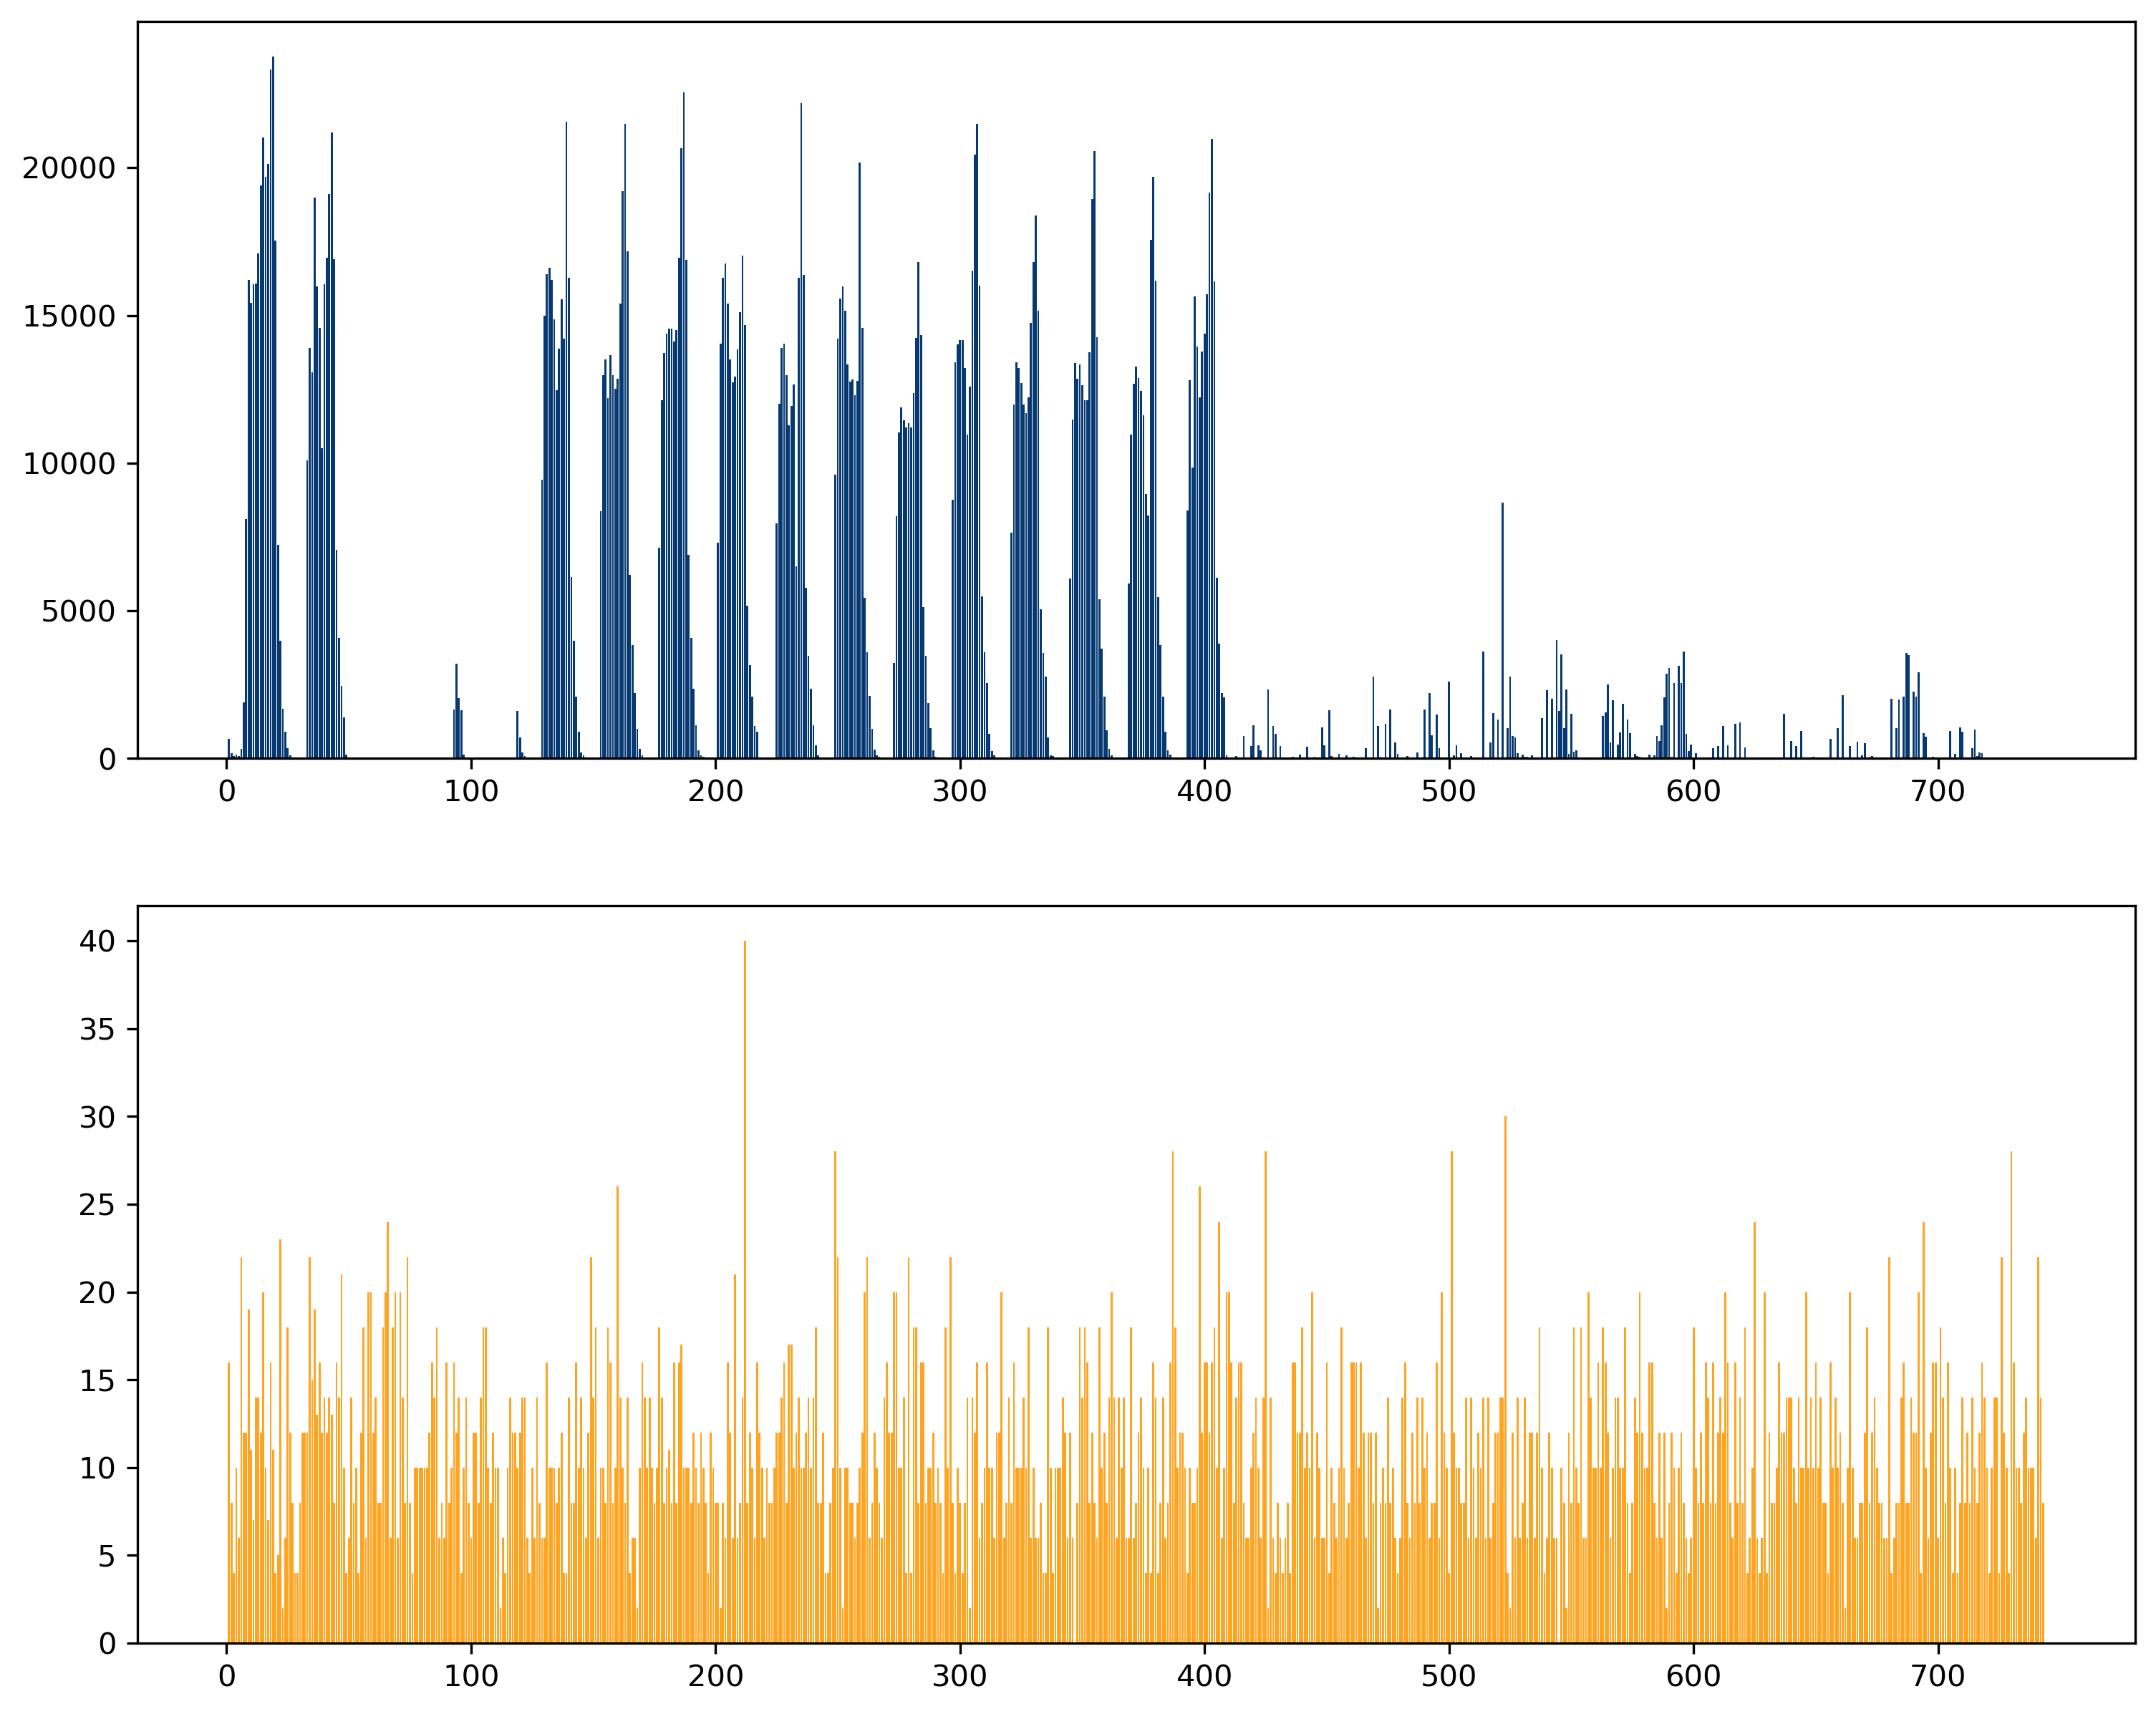

In [10]:
sql_script = \
"""
SELECT 
    step,
    COUNT(step) AS count,
    SUM(isFraud) AS fraud,
    ROUND(100*SUM(isFraud)/COUNT(step),2) AS fraud_rate
FROM filtered_fraud
GROUP BY step
"""
temp = spark.sql(sql_script).toPandas()

plt.figure(figsize=(12,10), dpi=300)
plt.subplot(2,1,1)
plt.bar(temp['step'],temp['count'],color='#063971')

plt.subplot(2,1,2)
plt.bar(temp['step'],temp['fraud'],color='#FFA420') 

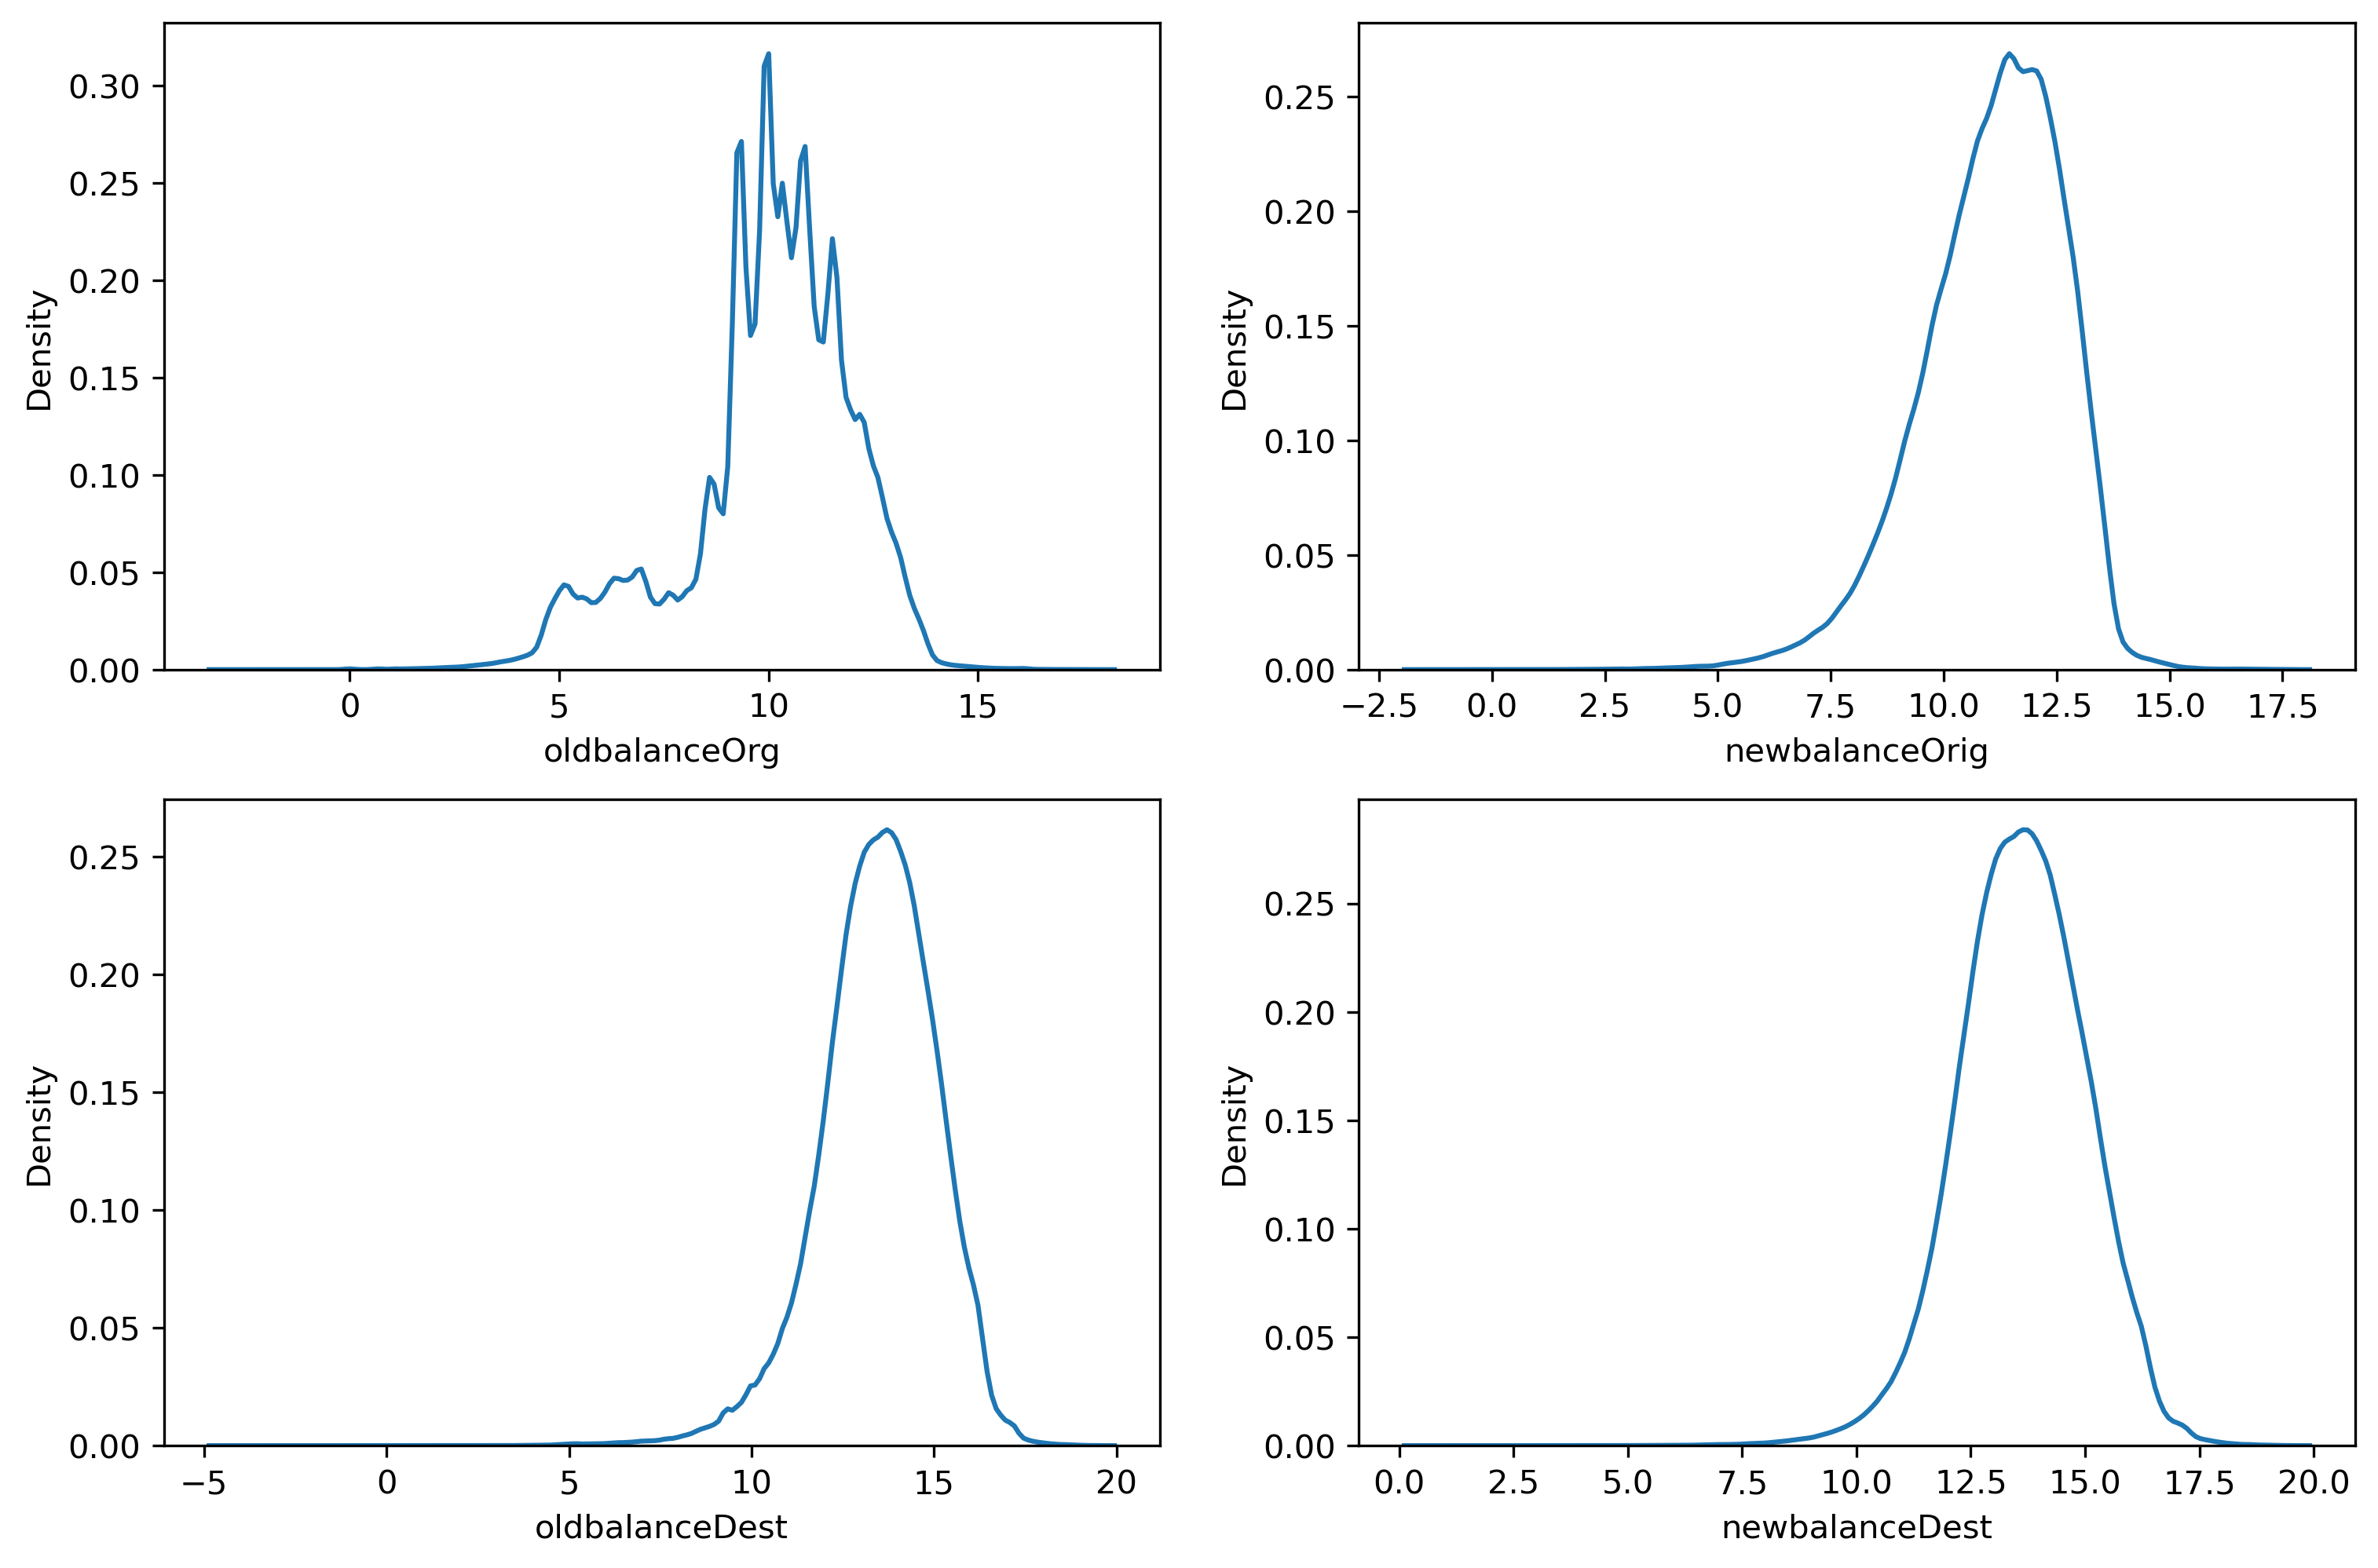

In [11]:
cols = ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
plt.figure(figsize=(12,8), dpi=300)
for i,col in enumerate(cols):
    sql_script = \
    f"""
    SELECT LOG({col}) AS {col}
    FROM filtered_fraud
    """
    temp = spark.sql(sql_script).toPandas()
    plt.subplot(2,2,i+1)
    sns.kdeplot(temp[col])

In [6]:
threshold = 100

sql_script = \
f"""
SELECT 
    oldbalanceOrg_status, 
    newbalanceOrig_status, 
    oldbalanceDest_status, 
    newbalanceDest_status, 
    SUM(isFraud) AS total_fraud
FROM (
    SELECT 
        (CASE
            WHEN oldbalanceOrg <= {threshold} THEN 'out_of_money'
            ELSE 'in_the_money'
        END) AS oldbalanceOrg_status,
        (CASE
            WHEN newbalanceOrig <= {threshold} THEN 'out_of_money'
            ELSE 'in_the_money'
        END) AS newbalanceOrig_status,
        (CASE
            WHEN oldbalanceDest <= {threshold} THEN 'out_of_money'
            ELSE 'in_the_money'
        END) AS oldbalanceDest_status,
        (CASE
            WHEN newbalanceDest <= {threshold} THEN 'out_of_money'
            ELSE 'in_the_money'
        END) AS newbalanceDest_status,
        isFraud
    FROM filtered_fraud) a
GROUP BY 
    oldbalanceOrg_status,
    newbalanceOrig_status,
    oldbalanceDest_status,
    newbalanceDest_status
SORT BY 
    oldbalanceOrg_status,
    newbalanceOrig_status,
    oldbalanceDest_status,
    newbalanceDest_status
"""

spark.sql(sql_script).show()

+--------------------+---------------------+---------------------+---------------------+-----------+
|oldbalanceOrg_status|newbalanceOrig_status|oldbalanceDest_status|newbalanceDest_status|total_fraud|
+--------------------+---------------------+---------------------+---------------------+-----------+
|        in_the_money|         in_the_money|         in_the_money|         in_the_money|          2|
|        in_the_money|         in_the_money|         in_the_money|         out_of_money|          0|
|        in_the_money|         in_the_money|         out_of_money|         in_the_money|          0|
|        in_the_money|         in_the_money|         out_of_money|         out_of_money|        158|
|        in_the_money|         out_of_money|         in_the_money|         in_the_money|       2819|
|        in_the_money|         out_of_money|         in_the_money|         out_of_money|         15|
|        in_the_money|         out_of_money|         out_of_money|         in_the_money|   

In [14]:
sql_script = \
"""
    SELECT 
        step%24 AS step,
        amount,
        oldbalanceOrg AS oldbalanceOrg,
        newbalanceOrig AS newbalanceOrig,
        oldbalanceDest AS oldbalanceDest,
        newbalanceDest AS newbalanceDest,
        newbalanceOrig - oldbalanceOrg AS orig_change,
        newbalanceDest - oldbalanceDest AS dest_change,
        oldbalanceOrg - oldbalanceDest AS oldbalance_diff,
        newbalanceOrig - newbalanceDest AS newbalance_diff,
        newbalanceOrig - oldbalanceOrg - amount AS orig_change_vs_amount,
        newbalanceDest - oldbalanceDest - amount AS dest_change_vs_amount,
        CASE
            WHEN type = 'TRANSFER' THEN 1
            ELSE 0
        END AS type_transfer,
        CASE
            WHEN type = 'CASH_OUT' THEN 1
            ELSE 0
        END AS type_cash_out,
        isFraud AS labels
    FROM filtered_fraud
"""

dataset = spark.sql(sql_script).toPandas()
dataset.head()
len(dataset)

2770409

In [15]:
X = dataset[dataset.columns[:14]]
y = dataset['labels']

nm = NearMiss(version=3)
X_res, y_res = nm.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, random_state=1, test_size=0.3, stratify=y_res)

/home/tungle/anaconda3/lib/python3.9/site-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:188: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(


In [48]:
clf = XGBClassifier(
    eval_metric='logloss',
    learning_rate = 0.01,
    max_depth=18,
    reg_lambda=3.8,
    subsample=1,
    n_estimators=500,
    use_label_encoder=False,
    tree_method='gpu_hist',
    predictor='gpu_predictor')

clf.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=False)

y_hat_train = clf.predict(X_train)
y_hat_test = clf.predict(X_test)
y_hat = clf.predict(X)

print("Train accuracy:",round(100*accuracy_score(y_hat_train,y_train),2),"%")
print("Test accuracy:",round(100*accuracy_score(y_hat_test,y_test),2),"%")
print("All accuracy:",round(100*accuracy_score(y_hat,y),2),"%")

print("Train precision:",round(100*precision_score(y_hat_train,y_train),2),"%")
print("Test precision:",round(100*precision_score(y_hat_test,y_test),2),"%")
print("All precision:",round(100*precision_score(y_hat,y),2),"%")

print('Train cm:')
print(confusion_matrix(y_hat_train,y_train))
print('Test cm:')
print(confusion_matrix(y_hat_test,y_test))
print('All cm:')
print(confusion_matrix(y_hat,y))

Train accuracy: 95.45 %
Test accuracy: 91.08 %
All accuracy: 98.74 %
Train precision: 92.83 %
Test precision: 88.23 %
All precision: 91.45 %
Train cm:
[[4251  412]
 [  45 5337]]
Test cm:
[[1748  290]
 [  94 2174]]
All cm:
[[2728114     702]
 [  34082    7511]]


In [45]:
predicted = filtered_df.toPandas()
predicted['predict'] = y_hat
predicted.to_parquet('./dataset/temp.parquet',engine='pyarrow')
df = spark.read.parquet('./dataset/temp.parquet')
df.createOrReplaceTempView('predicted')

In [46]:
sql_script = \
"""
SELECT
    status,
    COUNT(status) AS count,
    ROUND(SUM(amount)/1e6,2) AS total_amount,
    ROUND(SUM(amount)/COUNT(status), 2) AS amount_per_transaction
FROM (
    SELECT 
        (CASE
            WHEN isFraud = 1 AND predict = 1 THEN 'True Fraud - True predict'
            WHEN isFraud = 1 AND predict = 0 THEN 'True Fraud - False predict'
            WHEN isFraud = 0 AND predict = 1 THEN 'Not Fraud - False predict'
            WHEN isFraud = 0 AND predict = 0 THEN 'Not Fraud - True predict'
        END) AS status,
        amount
    FROM predicted ) a
GROUP BY status
SORT BY total_amount DESC
"""

temp = spark.sql(sql_script)
temp.show(truncate = False)
display(temp.toPandas())

+--------------------------+-------+------------+----------------------+
|status                    |count  |total_amount|amount_per_transaction|
+--------------------------+-------+------------+----------------------+
|Not Fraud - True predict  |2713826|858857.98   |316474.96             |
|True Fraud - True predict |7553   |11964.08    |1584016.41            |
|Not Fraud - False predict |48370  |8790.58     |181736.25             |
|True Fraud - False predict|660    |92.34       |139908.35             |
+--------------------------+-------+------------+----------------------+



,status,count,total_amount,amount_per_transaction
0,Not Fraud - True predict,2713826,858857.98,316474.96
1,True Fraud - True predict,7553,11964.08,1584016.41
2,Not Fraud - False predict,48370,8790.58,181736.25
3,True Fraud - False predict,660,92.34,139908.35
